<a href="https://colab.research.google.com/github/gitHubAndyLee2020/FinancialBERT/blob/main/financial_bert_rag_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### FinancialBERT RAG System

### API Keys

In [ ]:
%%writefile .env
NEWS_API_KEY=cbe23bc5d3msh0c01e8eaf7818e4p1ef4bejsn26881935c937
POLYGON_API_KEY=DosqC77v0kn8vveoHFgj7QGTrA4fYHvx
COHERE_API_KEY=gkdTOayxpLtUxnWESVTSSIf0oF6KW7b6HonEUPIc

Overwriting .env


### Files Uploading

In [ ]:
# Upload `model_regressor_weight_v2.pth` and `tickers_and_names.csv` here
from google.colab import files

uploaded = files.upload()

Saving model_regressor_weight_v2.pth to model_regressor_weight_v2.pth


In [ ]:
uploaded = files.upload()

Saving tickers_and_names.csv to tickers_and_names.csv


### Package Installations

In [ ]:
!pip install python-dotenv fuzzywuzzy python-Levenshtein cohere streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 99.7 MB/s eta 0:00:00


### Name-Ticker Module

In [ ]:
%%writefile name_ticker_module.py
import pandas as pd
from fuzzywuzzy import process  # Assuming fuzzywuzzy is used for string matching

# Load the CSV file into a DataFrame
tickers_and_names = pd.read_csv('tickers_and_names.csv')

def find_similar_names_and_tickers(query, threshold=80):
    # Find matches above a certain score threshold
    results = process.extractBests(query, tickers_and_names["Name"], score_cutoff=threshold)

    # Retrieve both name and ticker for each match
    matched_pairs = []
    for result in results:
        matched_name = result[0]
        matched_index = tickers_and_names[tickers_and_names["Name"] == matched_name].index[0]
        matched_ticker = tickers_and_names.loc[matched_index, "Ticker"]
        matched_pairs.append((matched_name, matched_ticker))

    return matched_pairs

Writing name_ticker_module.py


### News Search Module

In [ ]:
%%writefile news_search_module.py
from dotenv import load_dotenv
import requests
import os
from datetime import datetime

load_dotenv()  # This loads the variables from .env

# Load your ContextualWeb API key from environment variable
WEB_SEARCH_API_KEY = os.getenv('NEWS_API_KEY')
search_url = "https://contextualwebsearch-web-search-v1.p.rapidapi.com/api/Search/WebSearchAPI"

def news_search(company_name: str):
    headers = {
        "X-RapidAPI-Key": WEB_SEARCH_API_KEY,
        "X-RapidAPI-Host": "contextualwebsearch-web-search-v1.p.rapidapi.com"
    }
    params = {
        "q": f"{company_name} stock price finance news",
        "pageSize": 100,  # Limit the number of results
        "autoCorrect": "true",  # Enable auto-correction
        "freshness": "Month",  # Filter by the current month's news
    }

    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()

    current_month = datetime.now().month
    current_year = datetime.now().year

    filtered_articles = []
    for article in search_results["value"]:
        # Adjust the date format
        date_str = article["date"]
        # Convert date to ISO format
        published_date = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%fZ")

        if published_date.month == current_month and published_date.year == current_year:
            filtered_articles.append({
                'title': article['title'],
                'description': article['description'],
                'url': article['url'],
                'source': article['provider'][0]['name'] if article.get('provider') else 'Unknown',
                'published_at': published_date.isoformat(),
            })

    return filtered_articles


Overwriting news_search_module.py


### Polygon Module

In [ ]:
%%writefile polygon_module.py
from dotenv import load_dotenv
import requests
import os

load_dotenv()  # This loads the variables from .env

POLYGON_API_KEY = os.getenv('POLYGON_API_KEY')

# Monthly Stock Price History Data
def get_stock_price_history(ticker: str, start_date: str, end_date: str):
  # Polygon.io API URL for AAPL stock data
  url = f'https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/month/{start_date}/{end_date}?apiKey={POLYGON_API_KEY}'

  # Make the GET request
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Parse the JSON data
      data = response.json()
      return [result['vw'] for result in data['results']]
  else:
      print(f'Failed to retrieve data: {response.status_code}')

Writing polygon_module.py


### Calendar Module

In [ ]:
%%writefile calendar_module.py
import datetime
import calendar

def get_first_last_days():
    # Get the current date
    current_date = datetime.date.today()

    # Calculate the first day of the month 5 months ago
    past_year, past_month = current_date.year, current_date.month
    for _ in range(5):  # For 5 months
        if past_month == 1:
            past_month = 12
            past_year -= 1
        else:
            past_month -= 1
    past_first_day = datetime.date(past_year, past_month, 1)

    # Calculate the last day of the current month
    last_day = calendar.monthrange(current_date.year, current_date.month)[1]
    current_month_last_day = datetime.date(current_date.year, current_date.month, last_day)

    # Format the dates to the desired format
    past_month_first_day_str = past_first_day.strftime('%Y-%m-%d')
    current_month_last_day_str = current_month_last_day.strftime('%Y-%m-%d')

    # Generate list of year-month labels from 5 months ago to the next month
    year_month_labels = []
    year, month = past_year, past_month
    for _ in range(7):  # Including the current month and the next month
        year_month_labels.append(f"{year}-{str(month).zfill(2)}")
        month += 1
        if month > 12:
            month = 1
            year += 1

    return past_month_first_day_str, current_month_last_day_str, year_month_labels

Writing calendar_module.py


### Cohere Rerank Module

In [ ]:

%%writefile cohere_rerank_module.py
from dotenv import load_dotenv
import os
import cohere

load_dotenv()  # This loads the variables from .env

COHERE_API_KEY = os.getenv('COHERE_API_KEY')

co = cohere.Client(COHERE_API_KEY)

def rerank_search_results(company_name: str, search_results: list[str], top_n: int):
    query = f"Filter and prioritize news headlines explicitly discussing factors influencing {company_name}'s stock price, including market trends, financial reports, corporate announcements, and industry-specific news impacting {company_name}'s performance."
    results = co.rerank(model="rerank-english-v2.0", query=query, documents=search_results, top_n=top_n)
    return [result.document['text'] for result in results]

Overwriting cohere_rerank_module.py


### FinancialBERT Module

In [ ]:
%%writefile financial_bert_module.py
import torch
from torch import nn
from transformers import BertModel, BertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class FinBERTRegressor(nn.Module):
    def __init__(self, finbert_model_name="ProsusAI/finbert", hidden_size=768, output_size=1):
        super(FinBERTRegressor, self).__init__()
        # Load the FinBERT model
        self.finbert = BertModel.from_pretrained(finbert_model_name)

        # Regression layer
        self.regressor = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Get embeddings from FinBERT
        with torch.no_grad():  # No need to calculate gradients for FinBERT
            outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)

        # We use the [CLS] token's embedding for regression
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Pass through the regression layer
        return self.regressor(cls_embedding)

if not ('model' in globals()):
    model = FinBERTRegressor()
    model.to(device)
    model.regressor.load_state_dict(torch.load('model_regressor_weight_v2.pth'))

if not ('tokenizer' in globals()):
    tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

def predict_monthly_stock_price_change_rate(text: str):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Move the inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate output
    output = model(**inputs)

    return output.item()

Writing financial_bert_module.py


### Module Tests

In [ ]:
from name_ticker_module import find_similar_names_and_tickers
from news_search_module import news_search
from polygon_module import get_stock_price_history
from calendar_module import get_first_last_days
from cohere_rerank_module import rerank_search_results
from financial_bert_module import predict_monthly_stock_price_change_rate
import matplotlib.pyplot as plt

# Company Name Search
user_input = "Apple"
search_results = find_similar_names_and_tickers(user_input)
name, ticker = search_results[0]
print("Company Name Search:")
print(f"Name: {name}, Ticker: {ticker}")
print("\n\n")

this_month_articles = news_search(name)
articles_content = [article['description'] for article in this_month_articles]
print("Search News Articles:")
for article in articles_content:
    print("-", article)
print("\n\n")

Company Name Search:
Name: Apple Inc., Ticker: AAPL



Search News Articles:
- Kingfisher Capital LLC reduced its stake in shares of Apple Inc. (NASDAQ:AAPL – Free Report) by 0.2% in the 2nd quarter, HoldingsChannel reports. The firm owned 81,471 shares of the iPhone maker’s stock after selling 166 shares during the quarter. Apple makes…
- Element Pointe Advisors LLC lessened its holdings in shares of Apple Inc. (NASDAQ:AAPL – Free Report) by 3.1% during the second quarter, according to the company in its most recent filing with the Securities and Exchange Commission. The institutional investor…
- Point72 Hong Kong Ltd acquired a new stake in shares of Apple Inc. (NASDAQ:AAPL – Free Report) during the 2nd quarter, according to the company in its most recent disclosure with the Securities & Exchange Commission. The firm acquired 110,791 shares of the iP…
- APG Asset Management US Inc. decreased its holdings in Apple Inc. (NASDAQ:AAPL – Free Report) by 15.8% in the second quarter, accord

FinancialBERT Monthly Stock Price Change Rate:
-0.39832424372434616% change from current month's stock price (vw)



Polygon Stock Price History:
2024-06 stock price (vw): 207.98
2024-07 stock price (vw): 224.69
2024-08 stock price (vw): 219.94
2024-09 stock price (vw): 224.53
2024-10 stock price (vw): 229.97
2024-11 stock price (vw): 224.16
2024-12 stock price (vw): 223.27 (predicted)





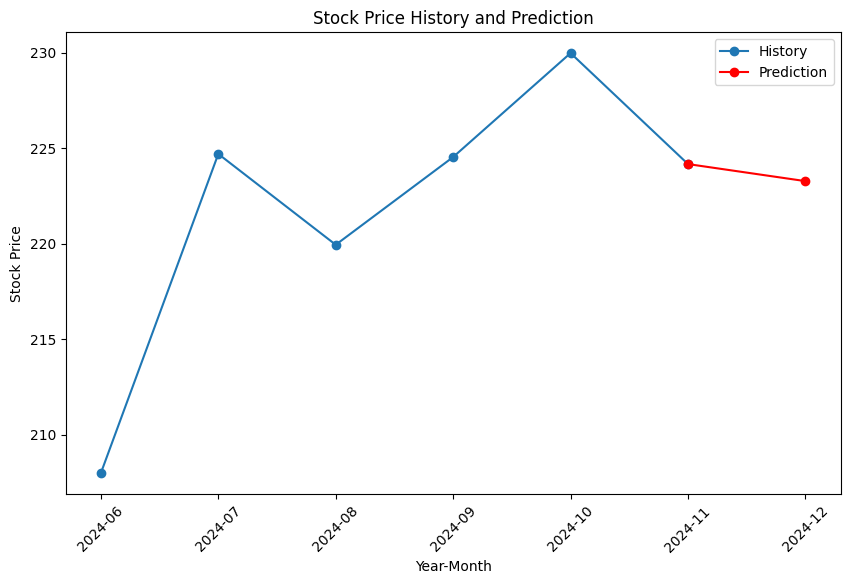

In [ ]:
reranked_articles_content = articles_content
concatenated_articles_content = " ".join([article for article in reranked_articles_content if article is not None])

monthly_stock_price_change_rate = predict_monthly_stock_price_change_rate(concatenated_articles_content)
print("FinancialBERT Monthly Stock Price Change Rate:")
print(f"{monthly_stock_price_change_rate * 100}% change from current month's stock price (vw)")
print("\n\n")

past_month_first_day_str, current_month_last_day_str, year_month_labels = get_first_last_days()
stock_price_history = get_stock_price_history(ticker, past_month_first_day_str, current_month_last_day_str)
predicted_next_month_stock_price = stock_price_history[-1] * (1 + monthly_stock_price_change_rate)
stock_price_history.append(predicted_next_month_stock_price)
print("Polygon Stock Price History:")
if len(year_month_labels) != len(stock_price_history):
    print("Error: Length of year_month_labels and stock_price_history do not match.")
    exit()
for index, year_month_label in enumerate(year_month_labels):
    if index == len(year_month_labels) - 1:
        print(f"{year_month_label} stock price (vw): {stock_price_history[index]:.2f} (predicted)")
    else:
      print(f"{year_month_label} stock price (vw): {stock_price_history[index]:.2f}")
print("\n\n")

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(year_month_labels[:-1], stock_price_history[:-1], label='History', marker='o')
plt.plot(year_month_labels[-2:], stock_price_history[-2:], label='Prediction', color='red', marker='o')

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Stock Price')
plt.title('Stock Price History and Prediction')
plt.xticks(rotation=45)

# Adding legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
from google.colab import files
import os

# Create a list of files to download
files_to_download = ['.env', 'name_ticker_module.py', 'newsapi_search_module.py', 'polygon_module.py',
                     'calendar_module.py', 'cohere_rerank_module.py', 'financial_bert_module.py']

# Download each file
for file in files_to_download:
  if os.path.exists(file):
    files.download(file)
  else:
    print(f"File not found: {file}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File not found: streamlit_app.py
